##**Overview**

Effieciency is something we strive to maximize, especially in the business sector where it can translate to minimizing losses, maximizing profits or having an edge over others. Data analysis and basic insights have played a key role in acheiving this but with an increasing need for better optimization, it's time to step up. There is a need for predictive forecasting ,on the basis of which business decisions can made and optimised better. One such domain where predictive forecasting makes a huge impact is SALES.
Having an estimate of point sales value helps in maintaining and updating stock,revenue estimation and other meaningful insights on which business decissions are made. Machine learning techniques and algorithms can be leveraged to deal with this type of predictive forecasting where there is a huge amount of data and a lot of factors weighing in; to consider.



##**Business Problem**

The M5 Forecasting – accuracy is a part of the M5 competition by MOFC, which asks the question *“Can
you estimate, as precisely as possible, the point forecasts of the unit sales of various products sold in the
USA by Walmart?*
It was a kaggle competition conducted in 2020 that uses hierarchical sales data from Walmart, the world’s
largest company by revenue, to forecast daily sales for the next 28 days. 

The objective of the M5 forecasting competition is to advance the theory and practice of forecasting by identifying the method(s) that provide the most accurate point forecasts for each of the 30,490 time series of the competition.

##**Data**

The data, covers stores in three
US States (California, Texas, and Wisconsin) and includes item level, department, product categories, and
store details. In addition, it has explanatory variables such as price, promotions, day of the week, and
special events. The historical data ranges from 2011-01-29 to 2016-06-19. 
Dataset is in the form of .csv files (3); calendar, sell_prices,
sales_train_evaluation

Dataset link: https://www.kaggle.com/competitions/m5-forecasting-accuracy/data

It is a multi-step time series forecasting. The number of forecasts required, both for point and probabilistic
forecasts, is h=28 days (4 weeks ahead).

The organization of data is as follows:
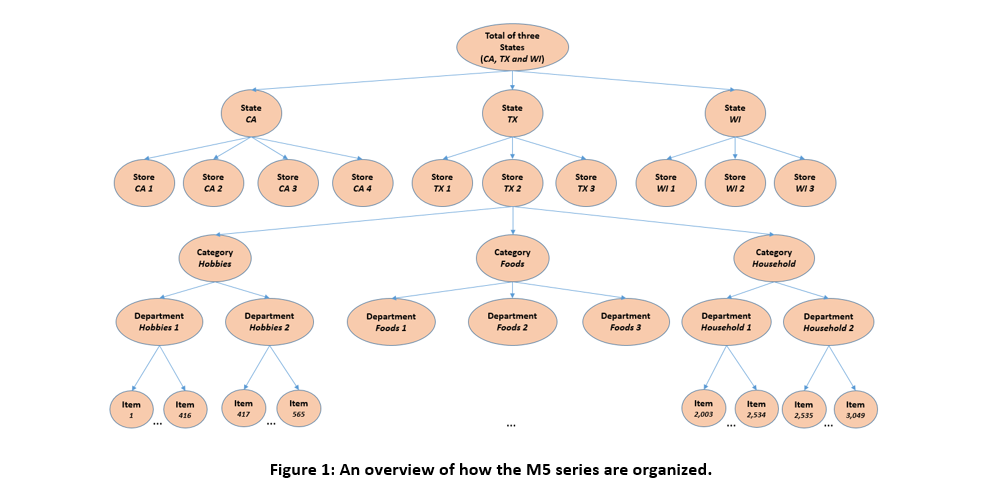

##**Preprocessing**

**Importing libraraies**

In [1]:
import pandas as pd
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import lightgbm as lgb
from prettytable import PrettyTable
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor

**Downcasting**

We are dealing with years of sales data over few stores, it's a lot of data to handle; requires more computational capacity. We can use a couple tricks to reduce the size of data processed, one of them is downcasting.

Python automatically saves data in int64,float64 or object type; by specifically analyzing the size of the maximum value and type, we can reduce it to a much smaller storage format. For categorical features, we can change it from object type to a more limited categorical type. This drastically reduces the memory usage.

In [ ]:
def downcasting(df):
  """ downcasts integer and float type , converts object type to category"""

  icols = df.select_dtypes('integer').columns
  fcols = df.select_dtypes('float').columns
  if len(icols)>0:
    df[icols] = df[icols].apply(pd.to_numeric, downcast='integer')
  if len(fcols)>0:
    df[fcols] = df[fcols].apply(pd.to_numeric, downcast='float')

  ocols = df.select_dtypes('object').columns
  for col in ocols:
    df[col] = df[col].astype('category')

###**Calendar data**

In [ ]:
g = pd.read_csv("calendar.csv")
g.head()

date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
0  2011-01-29     11101   Saturday     1      1  2011  d_1          NaN   
1  2011-01-30     11101     Sunday     2      1  2011  d_2          NaN   
2  2011-01-31     11101     Monday     3      1  2011  d_3          NaN   
3  2011-02-01     11101    Tuesday     4      2  2011  d_4          NaN   
4  2011-02-02     11101  Wednesday     5      2  2011  d_5          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN          NaN        0        0        0  
1          NaN          NaN          NaN        0        0        0  
2          NaN          NaN          NaN        0        0        0  
3          NaN          NaN          NaN        1        1        0  
4          NaN          NaN          NaN        1        0        1

Observations

*   calendar.csv has 14 columns and 1969 rows.
*   it has record of events_names and event_types on particular days.
*   has information on the dates of SNAP sales.
*   There are many Nan values.

To do

We need to convert the date into a format that makes more sense, fill in the missing values for days with no events in event_name and event_type columns.
Prices are for each item in each store, every week(wm_yr_wk).

Fill in the NAn values in particular columns with "no_event" for days with no events. extract the day number from the date.

In [ ]:
g = g.rename(columns={'d': 'day_no'})
g['event_name_1'].fillna("no_event",inplace=True)
g['event_type_1'].fillna("no_event",inplace=True)
g['event_name_2'].fillna("no_event",inplace=True)
g['event_type_2'].fillna("no_event",inplace=True)

ds=[]
for i in g.date:
    m=i.split("-")[2]
    ds.append(m)
g.date=ds
g.head()

date  wm_yr_wk    weekday  wday  month  year day_no event_name_1  \
0   29     11101   Saturday     1      1  2011    d_1     no_event   
1   30     11101     Sunday     2      1  2011    d_2     no_event   
2   31     11101     Monday     3      1  2011    d_3     no_event   
3   01     11101    Tuesday     4      2  2011    d_4     no_event   
4   02     11101  Wednesday     5      2  2011    d_5     no_event   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0     no_event     no_event     no_event        0        0        0  
1     no_event     no_event     no_event        0        0        0  
2     no_event     no_event     no_event        0        0        0  
3     no_event     no_event     no_event        1        1        0  
4     no_event     no_event     no_event        1        0        1

In [ ]:
print("memory usage before downcasting is:",g.memory_usage().sum(),'bytes')
downcasting(g)
print("memory usage after downcasting is:",g.memory_usage().sum(),'bytes')

memory usage before downcasting is: 220656 bytes
memory usage after downcasting is: 118993 bytes


In [ ]:
g.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   date          1969 non-null   category
 1   wm_yr_wk      1969 non-null   int16   
 2   weekday       1969 non-null   category
 3   wday          1969 non-null   int8    
 4   month         1969 non-null   int8    
 5   year          1969 non-null   int16   
 6   day_no        1969 non-null   category
 7   event_name_1  1969 non-null   category
 8   event_type_1  1969 non-null   category
 9   event_name_2  1969 non-null   category
 10  event_type_2  1969 non-null   category
 11  snap_CA       1969 non-null   int8    
 12  snap_TX       1969 non-null   int8    
 13  snap_WI       1969 non-null   int8    
dtypes: category(7), int16(2), int8(5)
memory usage: 116.2 KB


To check for final null values, dtype and memory usage we use .info() .
after basic preprocessing of calendar data , there are no null-values, Dtype has been optimized and the memory usage has been reduced.

###**Sales_train_evaluation data**

In [ ]:
h = pd.read_csv("sales_train_evaluation.csv")
h.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  ...  d_1932  d_1933  d_1934  d_1935  d_1936  \
0       CA    0    0    0    0  ...       2       4       0       0       0   
1       CA    0    0    0    0  ...       0       1       2       1       1   
2       CA    0    0    0    0  ...       1       0       2       0       0   
3       CA    0    0    0    0  ...       1       1       0       4       0   
4       CA    0    0    0    0  ...       0       0       0       2       1   

   d_1937  d_1938  d_1939  d_1940  d_1941  
0       0       3       3       0       1  
1       0       0       0       0       0  
2       0       2       3       0       1  
3       1       3       0       2       6  
4       0       0       2       1       0  

[5 rows x 1947 columns]

In [ ]:
for i in range(1942,1970):
  h["d_"+str(i)]=np.nan

In [ ]:
print("memory usage before downcasting is:",h.memory_usage().sum(),'bytes')
downcasting(h)
print("memory usage after downcasting is:",h.memory_usage().sum(),'bytes')

memory usage before downcasting is: 481742128 bytes
memory usage after downcasting is: 103838736 bytes


**Observations**

*   train_sales_evaluation.csv has 30490 rows and 1947 columns.
*   first 6 columns are id and information about the product, other 1941 are the daily unit sales values for 1941 days; in a long format. 28 more days that have to be predicted are added.


**To do**

Each value in the 1941 columns is a target value for a particular day,item and store. Since we are trying to predict point value sales given particular day, item and store, we have to convert the data into long format. This can be done by melting the data (pd.melt).

In [ ]:
k=pd.melt(h,id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],var_name='day_no')
k.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id day_no  value  
0       CA    d_1    0.0  
1       CA    d_1    0.0  
2       CA    d_1    0.0  
3       CA    d_1    0.0  
4       CA    d_1    0.0

In [ ]:
print("memory usage before downcasting is:",k.memory_usage().sum(),'bytes')
downcasting(k)
print("memory usage after downcasting is:",k.memory_usage().sum(),'bytes')

memory usage before downcasting is: 1202088536 bytes
memory usage after downcasting is: 841961516 bytes


###**Selling price data**

In [ ]:
b = pd.read_csv("sell_prices.csv")
b.head()

store_id        item_id  wm_yr_wk  sell_price
0     CA_1  HOBBIES_1_001     11325        9.58
1     CA_1  HOBBIES_1_001     11326        9.58
2     CA_1  HOBBIES_1_001     11327        8.26
3     CA_1  HOBBIES_1_001     11328        8.26
4     CA_1  HOBBIES_1_001     11329        8.26

In [ ]:
print("memory usage before downcasting is:",b.memory_usage().sum(),'bytes')
downcasting(b)
print("memory usage after downcasting is:",b.memory_usage().sum(),'bytes')

memory usage before downcasting is: 218916000 bytes
memory usage after downcasting is: 61661077 bytes


**Observations**



*   sell_prices.csv has the selling prices of each item, per store, per week.
*   has 4 columns: id, store_id, week number and sell prices.

###**Merging all Data**

To get to the final dataframe, We merge the columns of the sales_training data with calendar data, based on the day_no which gives adiitional information like special events, sales and time of the year. now we get a total of 21 columns. Now, the dataframe has an entry for each product in each store for each day.

remove 'd_' from day_no and downcast to int16.

In [ ]:
k=pd.merge(k,g,how='left',on='day_no')
k.day_no=k['day_no'].apply(lambda x: x.split('_')[1]).astype(np.int16)

print("memory usage  is:",k.memory_usage().sum(),'bytes')

memory usage  is: 2222683730 bytes


Since sell_prices is given on a weekly basis, we merge it in a way such that every day for a particular item at a particular store in that week has the same price.



In [ ]:
k=pd.merge(k,b,on=['store_id', 'item_id', 'wm_yr_wk'],how='left')
k.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  day_no  value date  wm_yr_wk  ... month  year  event_name_1  \
0       CA       1    0.0   29     11101  ...     1  2011      no_event   
1       CA       1    0.0   29     11101  ...     1  2011      no_event   
2       CA       1    0.0   29     11101  ...     1  2011      no_event   
3       CA       1    0.0   29     11101  ...     1  2011      no_event   
4       CA       1    0.0   29     11101  ...     1  2011      no_event   

   event_type_1 event_name_2 event_type_2 snap_CA snap_TX  snap_WI  sell_price  
0      no_event     no_event     no_event       0       0        0         NaN  
1      no_event     no_event     no_event       0       0        0         NaN  
2      no_event     no_event     no_event       0       0        0         NaN  
3      no_event     no_event     no_event       0       0        0         NaN  
4      no_event     no_event     no_event       0       0        0         NaN  

[5 rows x 22 columns]

After merging all the data accordingly, we see that


*   There are now 22 columns and 60034810 rows.
*   Sell_price column has many Nan values

###**Selling_price imputation**

After merging the data, we can see many Nan values in the sell_price, these missing values can either indicate absence of the product at that particular store during a week or zero quantity purchase. Thus, indicating that missing values in sell_price also has some valuable information to add.
we can retreive this information by assigning a bool, if that particular sell_price value is missing.
we can also impute those missing values by observing that particular product's sell_price over a time.
for imputation of values , we pivot the table to wide form so that we can interpolate prices row wise and then convert it back to long form and merge with the main dataframe to get the final one. We do this after merging all other data so that even the missing days of sell_price has an entry. pickle this dataframe for exploring and using later.


In [ ]:
ff=k[['id','day_no','sell_price']]
ff.head()

id  day_no  sell_price
0  HOBBIES_1_001_CA_1_evaluation       1         NaN
1  HOBBIES_1_002_CA_1_evaluation       1         NaN
2  HOBBIES_1_003_CA_1_evaluation       1         NaN
3  HOBBIES_1_004_CA_1_evaluation       1         NaN
4  HOBBIES_1_005_CA_1_evaluation       1         NaN

In [ ]:
ff=ff.pivot(index='id',columns='day_no',values='sell_price')
ff.head()

day_no                       1     2     3     4     5     6     7     8     \
id                                                                            
FOODS_1_001_CA_1_evaluation   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   
FOODS_1_001_CA_2_evaluation   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   
FOODS_1_001_CA_3_evaluation   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   
FOODS_1_001_CA_4_evaluation   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   
FOODS_1_001_TX_1_evaluation   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   

day_no                       9     10    ...  1960  1961  1962  1963  1964  \
id                                       ...                                 
FOODS_1_001_CA_1_evaluation   2.0   2.0  ...  2.24  2.24  2.24  2.24  2.24   
FOODS_1_001_CA_2_evaluation   2.0   2.0  ...  2.24  2.24  2.24  2.24  2.24   
FOODS_1_001_CA_3_evaluation   2.0   2.0  ...  2.24  2.24  2.24  2.24  2.24   
FOODS_1_001_CA_4_evaluation   2.0   2.0  ...  2.24  2.24  2.24  2.24  2.24   
FOODS_1_001_TX_1_evaluation   2.0   2.0  ...  2.24  2.24  2.24  2.24  2.24   

day_no                       1965  1966  1967  1968  1969  
id                                                         
FOODS_1_001_CA_1_evaluation  2.24  2.24  2.24  2.24  2.24  
FOODS_1_001_CA_2_evaluation  2.24  2.24  2.24  2.24  2.24  
FOODS_1_001_CA_3_evaluation  2.24  2.24  2.24  2.24  2.24  
FOODS_1_001_CA_4_evaluation  2.24  2.24  2.24  2.24  2.24  
FOODS_1_001_TX_1_evaluation  2.24  2.24  2.24  2.24  2.24  

[5 rows x 1969 columns]

In [ ]:
print("number of Nan values before imputation:",sum(ff.isna().sum()))

number of Nan values before imputation: 12299413


In [ ]:
ff.interpolate(limit_direction='backward',inplace=True,axis=1)
print("number of Nan values after interpolation:",sum(ff.isna().sum()))

number of Nan values after interpolation: 0


In [ ]:
ff=pd.melt(ff,ignore_index=False,value_name='sell_price')
ff=ff.reset_index(level=0)
downcasting(ff)
ff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60034810 entries, 0 to 60034809
Data columns (total 3 columns):
 #   Column      Dtype   
---  ------      -----   
 0   id          category
 1   day_no      int16   
 2   sell_price  float32 
dtypes: category(1), float32(1), int16(1)
memory usage: 459.3 MB


In [ ]:
k['imputed']=k['sell_price'].isna()
k=k.drop(['sell_price'],axis=1)

**Final data**

After merging all the data, imputation of sell_price values and adding an 'imputed' column; we get the final dataframe that we can pickle(store) and use it for further Exploratory Data Analysis.

The final dataframe now has 23 columns and 60034810 rows.

In [ ]:
k=pd.merge(k,ff,on=['id','day_no'])
k.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  day_no  value date  wm_yr_wk  ...  year  event_name_1  \
0       CA       1    0.0   29     11101  ...  2011      no_event   
1       CA       1    0.0   29     11101  ...  2011      no_event   
2       CA       1    0.0   29     11101  ...  2011      no_event   
3       CA       1    0.0   29     11101  ...  2011      no_event   
4       CA       1    0.0   29     11101  ...  2011      no_event   

   event_type_1  event_name_2 event_type_2 snap_CA snap_TX snap_WI  imputed  \
0      no_event      no_event     no_event       0       0       0     True   
1      no_event      no_event     no_event       0       0       0     True   
2      no_event      no_event     no_event       0       0       0     True   
3      no_event      no_event     no_event       0       0       0     True   
4      no_event      no_event     no_event       0       0       0     True   

   sell_price  
0        9.58  
1        3.97  
2        2.97  
3        4.34  
4        2.98  

[5 rows x 23 columns]

In [ ]:
#Pickling data
filename = 'final'
outfile = open(filename,'wb')
pickle.dump(k,outfile)
outfile.close()

##**EDA**

In [ ]:
#retreiving data from pickle file
infile = open('final','rb')
k = pickle.load(infile)
infile.close()

k=k[(k.day_no<=1913)]

In [ ]:
k.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  day_no  value date  wm_yr_wk  ...  year  event_name_1  \
0       CA       1    0.0   29     11101  ...  2011      no_event   
1       CA       1    0.0   29     11101  ...  2011      no_event   
2       CA       1    0.0   29     11101  ...  2011      no_event   
3       CA       1    0.0   29     11101  ...  2011      no_event   
4       CA       1    0.0   29     11101  ...  2011      no_event   

   event_type_1  event_name_2 event_type_2 snap_CA snap_TX snap_WI  imputed  \
0      no_event      no_event     no_event       0       0       0     True   
1      no_event      no_event     no_event       0       0       0     True   
2      no_event      no_event     no_event       0       0       0     True   
3      no_event      no_event     no_event       0       0       0     True   
4      no_event      no_event     no_event       0       0       0     True   

   sell_price  
0        9.58  
1        3.97  
2        2.97  
3        4.34  
4        2.98  

[5 rows x 23 columns]

###**Data Description**

**Unit sales value (in millions) across differnt stores and departments**

The given sales data is across 10 stores in three states(CA, TX, WI), 7 dept_id's in 3 categories (Food, Hobby, Household). The distribution of data across stores and departments can be seen below. The bar graph plotted shows value ( unit sales value) sold over the whole time (in million) for each store.

<Figure size 1080x1080 with 0 Axes>

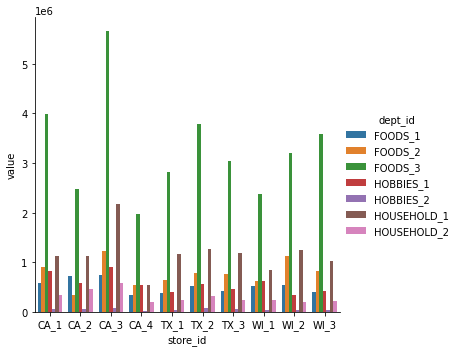

In [ ]:
hi=k[['store_id','dept_id','value']].groupby(['store_id','dept_id']).sum()
ghi=pd.DataFrame(hi.reset_index())
plt.figure(figsize = (15,15))
sns.catplot(data=ghi, kind="bar", x="store_id", y="value", hue="dept_id")

**Observations**


*   The proportion of dept. wise sales for each store is similar.
*   CA_3 seems to have to max sales overall, CA_4 the least; might indicate size of stores.
*   FOODS_3 has the max number of unit sales whereas HOBBIES_2 has the least.

###**Numerical Trends**

To seek an idea of the basic trends between numerical features, we can compute the correlation coefficient of each pair and compare to check which features are more related, how much each feature is correlated to the unit value sales and in which direction. this can be done by using .corr, a heatmap helps to compare these values. 

In [ ]:
k.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'day_no',
       'value', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'imputed', 'sell_price'],
      dtype='object')

In [ ]:
d=k[['day_no','value', 'date', 'wm_yr_wk', 'year',
       'snap_CA', 'snap_TX', 'snap_WI','sell_price','imputed']]
e=d.corr()
e

day_no     value  wm_yr_wk      year   snap_CA   snap_TX  \
day_no      1.000000  0.034278  0.995996  0.983495 -0.004570 -0.001235   
value       0.034278  1.000000  0.034740  0.034142  0.011284  0.013194   
wm_yr_wk    0.995996  0.034740  1.000000  0.989229  0.000716  0.002462   
year        0.983495  0.034142  0.989229  1.000000  0.008541  0.008541   
snap_CA    -0.004570  0.011284  0.000716  0.008541  1.000000  0.402881   
snap_TX    -0.001235  0.013194  0.002462  0.008541  0.402881  1.000000   
snap_WI    -0.000865  0.013394  0.002664  0.008541  0.402881  0.552161   
sell_price  0.007480 -0.131309  0.007456  0.007355 -0.000038 -0.000006   
imputed    -0.448273 -0.149673 -0.445399 -0.438280  0.003017  0.001297   

             snap_WI  sell_price   imputed  
day_no     -0.000865    0.007480 -0.448273  
value       0.013394   -0.131309 -0.149673  
wm_yr_wk    0.002664    0.007456 -0.445399  
year        0.008541    0.007355 -0.438280  
snap_CA     0.402881   -0.000038  0.003017  
snap_TX     0.552161   -0.000006  0.001297  
snap_WI     1.000000    0.000001  0.001137  
sell_price  0.000001    1.000000  0.020369  
imputed     0.001137    0.020369  1.000000

**Correlation heatmap**

<AxesSubplot:>

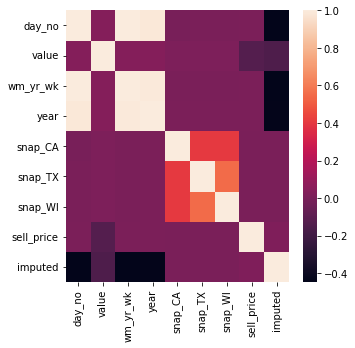

In [ ]:
plt.figure(figsize = (5,5))
sns.heatmap(e)

**Basic Trends**



*   From the above plotted heatmap, we can see the basic trends like how time realted feautes have stronger relationships
*   SNAP sale dates in different cities are strongly related
*   The imputed values bool is correlated with time; which might suggest that there are more imputed values in a particular time frame (zero stock).
*   The unit sales value seems to be correlated with time based features(year,day_no,wm_yr_wk), day of the week, sell_price and imputed bool.
*    SNAP sale also has some affect on unit sales value.
*   sell_price and unit sale value has a negative corr. coef. , which indicates a negative relationship i.e when one goes up , other goes downward.


To see the relationship between days passed(time) and unit sales value, we can plot a time_series plot which shows sales over a period of time.

###**Time features analysis**

**Unit sales value vs day_no (hue:month)**

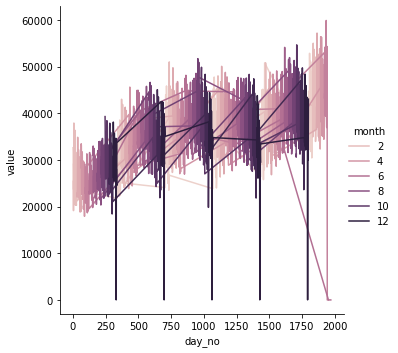

In [ ]:
hi=k[['day_no','month','value']].groupby(['day_no','month']).sum()
ghi=pd.DataFrame(hi.reset_index())
sns.relplot(data=ghi, kind="line", x="day_no", y="value", hue="month")

**Observations**



*   From the above time-series plot we can see that the unit sales values has an overall increasing trend over the years.
*   month wise, the same month of the further years record increased sales mostly, there are some anomalies.
*   December month seems to have an event day (christmas) that has alomst zero or no sales; indicates holiday.
*   the last couple months of the year seem to have relatively lesser sales value than other months every year.     

**Avg. unit sales per item on a average day of a particular month**

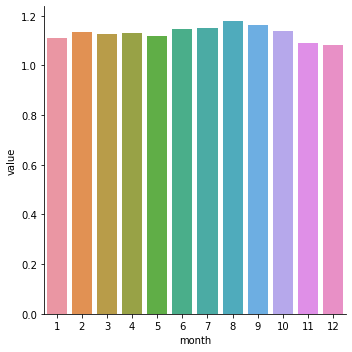

In [ ]:
hi=k[['month','value']].groupby(['month']).mean()
ghi=pd.DataFrame(hi.reset_index())
ghi
sns.catplot(data=ghi, x="month", y="value",kind='bar')

**Observations**


*   As indicated from the time-series plot, we can see that the 11th and 12th month overall sales is lesser compared to other months over the year.
*   6th-10th month relatively has more sales. could be an seasonal increase of products from a particular dept.

The sales values are an average of each item sold in a day for that month.

**Unit sales per month over the years in each dept.**

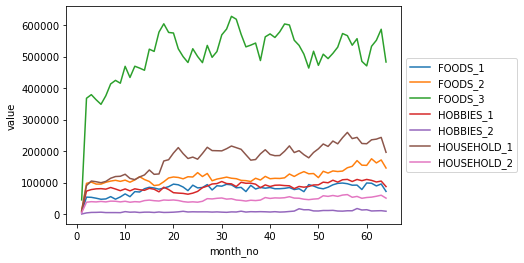

In [ ]:
k["month_no"] = k.month + (k.year-2011)*12
hi=k[['month_no','value','dept_id']].groupby(['month_no','dept_id']).sum()
ghi=pd.DataFrame(hi.reset_index())
l=sns.lineplot(data=ghi, x="month_no", y="value",hue='dept_id')
l.legend(loc='center left', bbox_to_anchor=(1, 0.5))

**Unit sales per month over the years in each store**

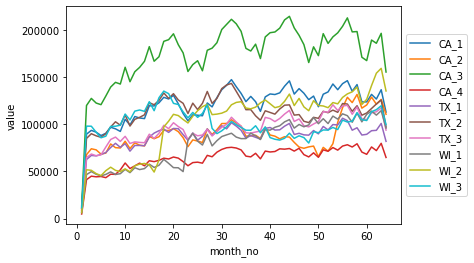

In [ ]:
hi=k[['month_no','value','store_id']].groupby(['month_no','store_id']).sum()
ghi=pd.DataFrame(hi.reset_index())
l=sns.lineplot(data=ghi, x="month_no", y="value",hue='store_id')
l.legend(loc='center left', bbox_to_anchor=(1, 0.5))
k=k.drop(['month_no'],axis=1)

Observations



*   There seems to be a yearly trend in sales, both store and dept. wise.
*   WI state has seen a drastic change in sales over the years.
*   CA_1 has always had a higher sales margin over other stores.
*   FOODS_3 dept. has the highest unit sales over other depts. all along.
*   HOBBIES_2 has seen an slightly more increasing demand over time, than others.










**Avg. item unit sales of a day in the month , store wise**

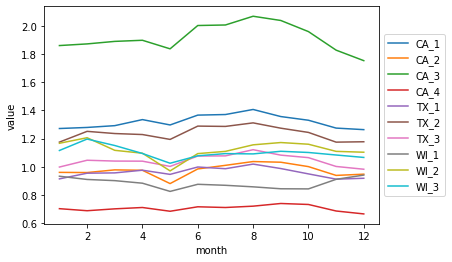

In [ ]:
hi=k[['month','value','store_id']].groupby(['month','store_id']).mean()
ghi=pd.DataFrame(hi.reset_index())
l=sns.lineplot(data=ghi, x="month", y="value",hue='store_id')
l.legend(loc='center left', bbox_to_anchor=(1, 0.5))

**Avg. item unit sales of a day in the month, store wise**

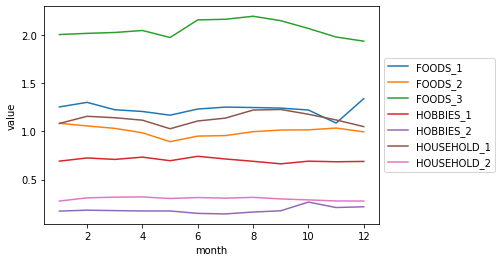

In [ ]:
hi=k[['month','value','dept_id']].groupby(['month','dept_id']).mean()
ghi=pd.DataFrame(hi.reset_index())
l=sns.lineplot(data=ghi, x="month", y="value",hue='dept_id')
l.legend(loc='center left', bbox_to_anchor=(1, 0.5))

**Observation**


*   From the linegraph of unit sales vs month , we can see particular seasonal trend (months) where sales of particular dept.,store is higher or lower than usual.
*   Month of May and November seems to cause a sudden, slight dip in sales particularly.
*   Month of August seems a slight pump in sales over other months, both store and dept. wise.
*   CA_3 store and FOODS_3 dept. has higher per day avg. unit sales in every month.





**Avg. unit sales per item across all days in a month**

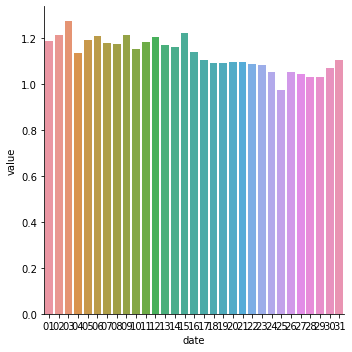

In [ ]:
hi=k[['date','value']].groupby(['date']).mean()
ghi=pd.DataFrame(hi.reset_index())
ghi
sns.catplot(data=ghi, x="date", y="value",kind='bar')

To check the date wise trends in a month, we plot an average sales per date graph. 

**Observation**

*   we can see that the initial week has the highest sales, which keeps on reducing till the last week of the month; which might indicate spending power over a month, habits.




**Avg. unit sales per item across each category and store on different days of the week**

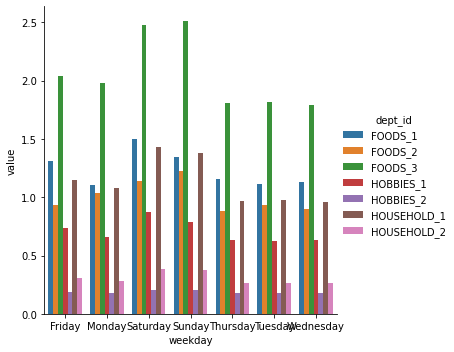

In [ ]:
hi=k[['weekday','dept_id','value']].groupby(['weekday','dept_id']).mean()
ghi=pd.DataFrame(hi.reset_index())
sns.catplot(data=ghi, kind="bar", x="weekday", y="value", hue="dept_id")

To check daily trends over a week , we plot a bar graph for average sales for each day in a week over the whole data; across deptartments.

**Observations**



*   Saturday and Sunday seems to be the most prominent days for overall sales
*   friday has somewhat similar but slightly lower trend.
*   The proportion of dept. wise sales seems to be similar all over the week. indicating more inflow of customers on the weekend.

**Autocorrelation to find periodicity/seasonality**

23656


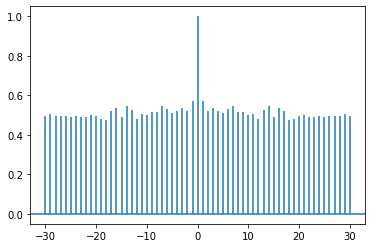

27579


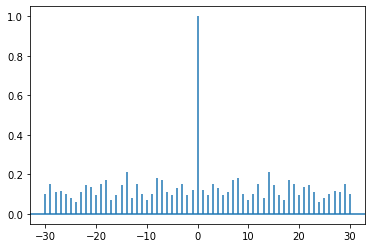

21415


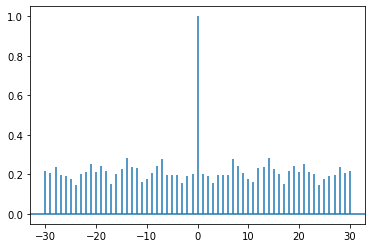

In [ ]:
h = pd.read_csv("sales_train_evaluation.csv")

for i in range(3):
    a=np.random.randint(len(h))
    print(a)
    data=h.loc[:,'d_'+str(1069):"d_"+str(1913)]
    row=data.iloc[a].values
    row=np.array(row,dtype='float')
    plt.acorr(row,maxlags=30)
    plt.show()

**Autocorrelation - state wise**

CA


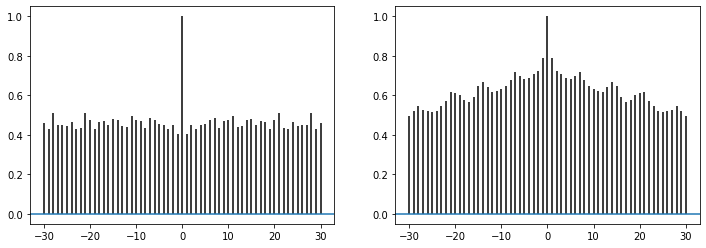

TX


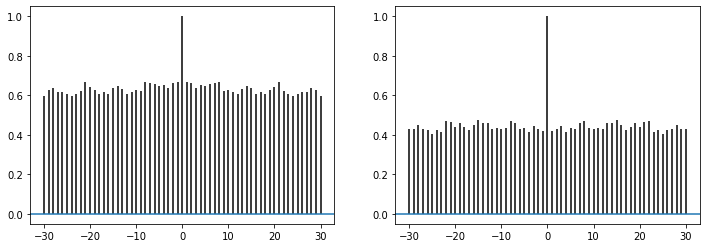

WI


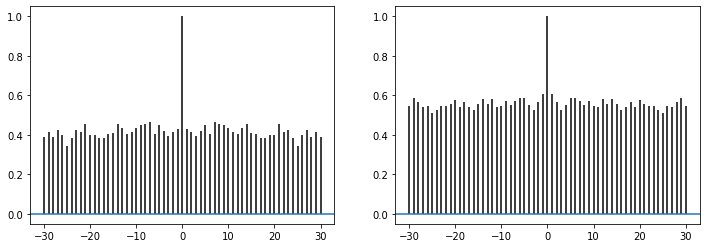

In [6]:
h = pd.read_csv("sales_train_evaluation.csv")
states=["CA","TX","WI"]

for i in states:
  q=h[(h.state_id==i)].reset_index(drop=True)
  fig, ax = plt.subplots(1, 2, figsize=(12,4))
  print(i)
  for j in range(2):
    a=np.random.randint(len(q))
    data=h.loc[:,'d_'+str(1069):"d_"+str(1913)]
    row=data.iloc[a].values
    row=np.array(row,dtype='float')
    plt.subplot(1, 2, j+1)
    plt.acorr(row,maxlags=30)
  plt.show()

In order to check the periodicity, we randomly select few SKUs and analyze their sales value autocorrelation. it is observed that every instance has its own, somewhat unique pattern of periodicity but When closely observed , most of them have their highest autocorrelation value at a lag of around '7' days and its multiples. This validates the observation of weekly trends that we had seen earlier. Although every SKU has its own induvidual pattern, it is important to have an idea of the general periodicty as it would be later utilized in designing more efficient features.

###**Events and SNAP sales**

**Event_name_1 vs avg. unit sales per item on that day**

<BarContainer object of 31 artists>

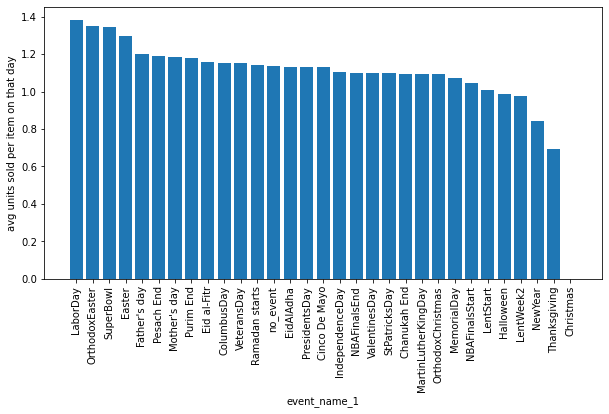

In [ ]:
hi=k[['event_name_1','value']].groupby(['event_name_1']).mean()
ghi=pd.DataFrame(hi.reset_index()).sort_values(by='value',ascending=False,ignore_index=True)
plt.figure(figsize = (10,5))
plt.xticks(rotation='vertical')
plt.xlabel("event_name_1")
plt.ylabel("avg units sold per item on that day")
plt.bar(ghi.event_name_1,ghi.value)

**Avg. unit sales per item on event_2_name days**

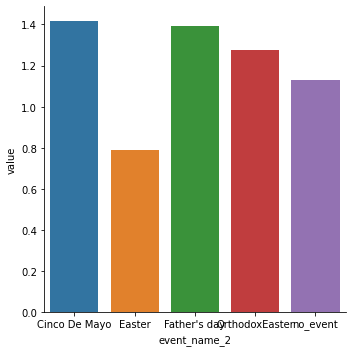

In [ ]:
hi=k[['event_name_2','value']].groupby(['event_name_2']).mean()
ghi=pd.DataFrame(hi.reset_index())
sns.catplot(data=ghi, x="event_name_2", y="value",kind='bar')

To see if event days have any effect on the sales value, we plot the avg units sold per item on all these different event days. we also plot the average sales for a normal day when there is no event, in order to compare.

**Observations**

*   we can see that few events like labor day , orthodox easter contribute more sales but there are event days like newyear and thanksgiving where the sales is lesser than average.
*   Christmas being an all around exception where the sales is almost null. this might be due to a holiday.
*   event_2 type also has similar trends, where the event somewhat affects the sales of that particular day. (Easter has lesser whereas cinco de mayo has the highest sales compared to a normal day)





 



**SNAP SALES**

In order to see how SNAP sale dates affect the overall sales on that day, we need to compare sales of a non-SNAP day around the same time period in a particular state; since the snap days are different for each state. from corr. plot we saw that SNAP dates over states are closely related.
SNAP days are spread all over the year making it easier to compare with a normal day when plotted in a time series graph comparision.


**SNAP vs non-SNAP day sales over the years (CA)**

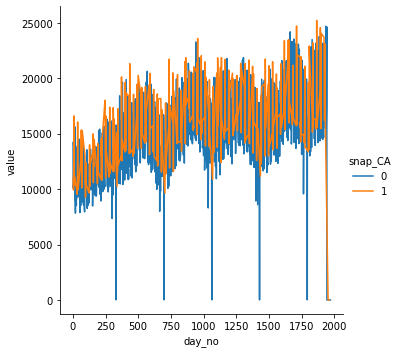

In [ ]:
hi=k[['day_no','snap_CA','value']][k.state_id=='CA'].groupby(['day_no','snap_CA']).sum()
ghi=pd.DataFrame(hi.reset_index())
sns.relplot(data=ghi, kind="line", x="day_no", y="value", hue="snap_CA")

**SNAP vs non-SNAP day sales over the years (TX)**

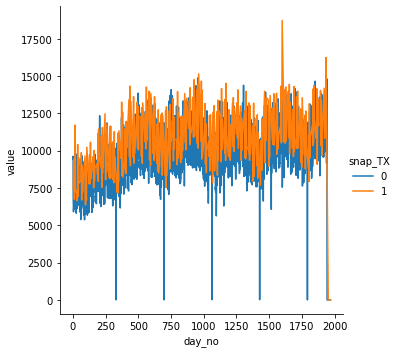

In [ ]:
hi=k[['day_no','snap_TX','value']][k.state_id=='TX'].groupby(['day_no','snap_TX']).sum()
ghi=pd.DataFrame(hi.reset_index())
sns.relplot(data=ghi, kind="line", x="day_no", y="value", hue="snap_TX")

**SNAP vs non-SNAP day sales over the years (WI)**

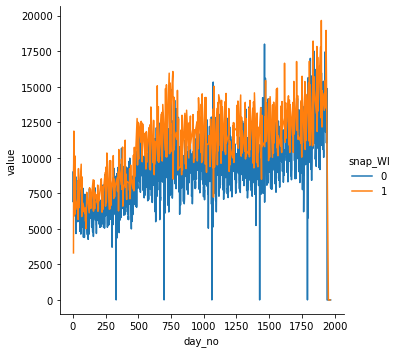

In [ ]:
hi=k[['day_no','snap_WI','value']][k.state_id=='WI'].groupby(['day_no','snap_WI']).sum()
ghi=pd.DataFrame(hi.reset_index())
sns.relplot(data=ghi, kind="line", x="day_no", y="value", hue="snap_WI")

**Observations**

*   From the above time series comparision plots, we see that SNAP sale days in general record more sales than a non-SNAP day in a similar timeframe.
*   it affects on a diffrent scale for different states.
*   WI has the highest difference in sales between a SNAP and a non SNAP day.
*   TX has a moderate difference whereas CA SNAP days although do record higher sales but not much as of a difference when compared.

###**Sale_price**

From the correlation plot, we see that sell_price affects the unit sales, to see how it affects store wise and dept. wise we plot a lineplot of the average sell_price of all the items in that particular store,dept. over time.

**Avg. sale price across stores and time**

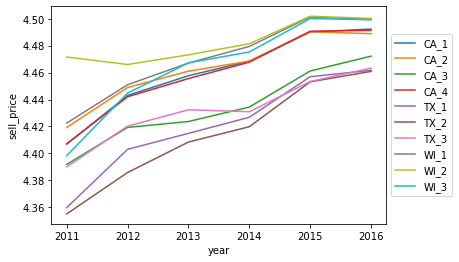

In [ ]:
hi=k[['year','sell_price','store_id']].groupby(['year','store_id']).mean()
ghi=pd.DataFrame(hi.reset_index())
l=sns.lineplot(data=ghi, x="year", y="sell_price",hue='store_id')
l.legend(loc='center left', bbox_to_anchor=(1, 0.5))

**Avg. sale price across departments and time**

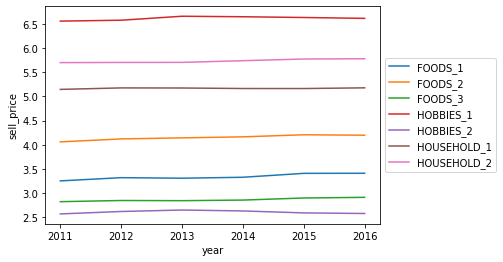

In [ ]:
hi=k[['year','sell_price','dept_id']].groupby(['year','dept_id']).mean()
ghi=pd.DataFrame(hi.reset_index())
l=sns.lineplot(data=ghi, x="year", y="sell_price",hue='dept_id')
l.legend(loc='center left', bbox_to_anchor=(1, 0.5))

**Observations**

*   from the avg. unit price vs state graph , we can see that sell prices across states have been slightly different , with WI stores having the highest prices then CA followed by TX. which has been increasing over time.
*   from the avg. unit price vs dept. plot , we can infer that hobbies dept. has the highest per unit prices, then household, then food. the prices of all the dept. has been increasing over time with a steady , small and similar rate.

**Fraction of sell_price values imputed over the years.**

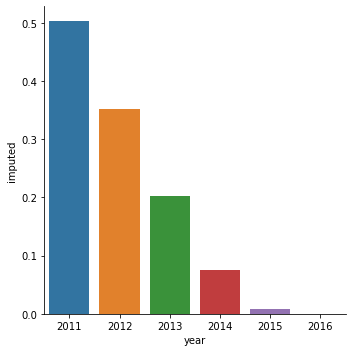

In [ ]:
hi=k[['year','imputed']].groupby(['year']).mean()
ghi=pd.DataFrame(hi.reset_index())
sns.catplot(data=ghi, x="year", y="imputed",kind='bar')

**Observation**

if we plot the number of sell_price values imputed over the years , we can see there is an exponential decrease. this can mean that new items have been added over the years at an exponential rate, sales of particular items have grown over the years or the stock of different items have been made available at regular intervals.

**Sell_price variations**

To see the variations of sell_price over stores, depts. we plot a violin plot which gives us a brief idea of how sell_prices for different items are distributed and in what range.

**violin plot to see distributions of sell_price across states**

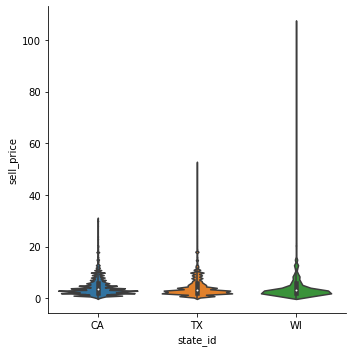

In [ ]:
hi=k[['sell_price','state_id']]
sns.catplot(data=hi, kind="violin", x="state_id", y="sell_price")

**violin plot to see distributions of sell_price across departments.**

<Figure size 720x360 with 0 Axes>

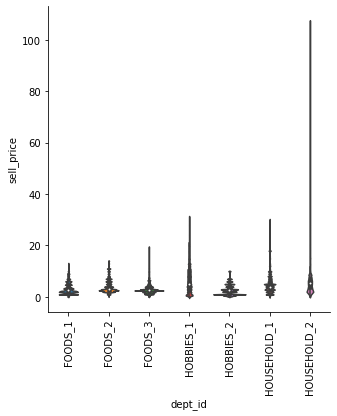

In [ ]:
hi=k[['sell_price','dept_id']]
plt.figure(figsize=(10,5))
sns.catplot(data=hi, kind="violin", x="dept_id", y="sell_price")
plt.xticks( rotation=90)
plt.show()

**Observations**

*   Across differnt states, we can see that they have similar but meticulously; differnt distributions, with WI having a lot of similar items which are priced way high than other states. CA and TX has a more limited price range over all categories.
*   Across various depts. sell prices take unique shapes giving them induviduality. HOusehold_2 items are the most priciest ones with items ranging over a huge price range. since we saw that only the state of WI has such abnormal values of sales_Price , we can intepret that the household_2 type items in WI may be highly priced maybe due to the increased demand or scarcity of such items in that area.

Since sell_price has a reasonable effect on the unit sales , factors that affect sell_price should also be monitored.

##**Forecasting - Methods and Approaches**

In [ ]:
#retreiving data from pickle file
infile = open('content/final','rb')
k = pickle.load(infile)
infile.close()

###**Metrics**

**Typical time series performance metrics**

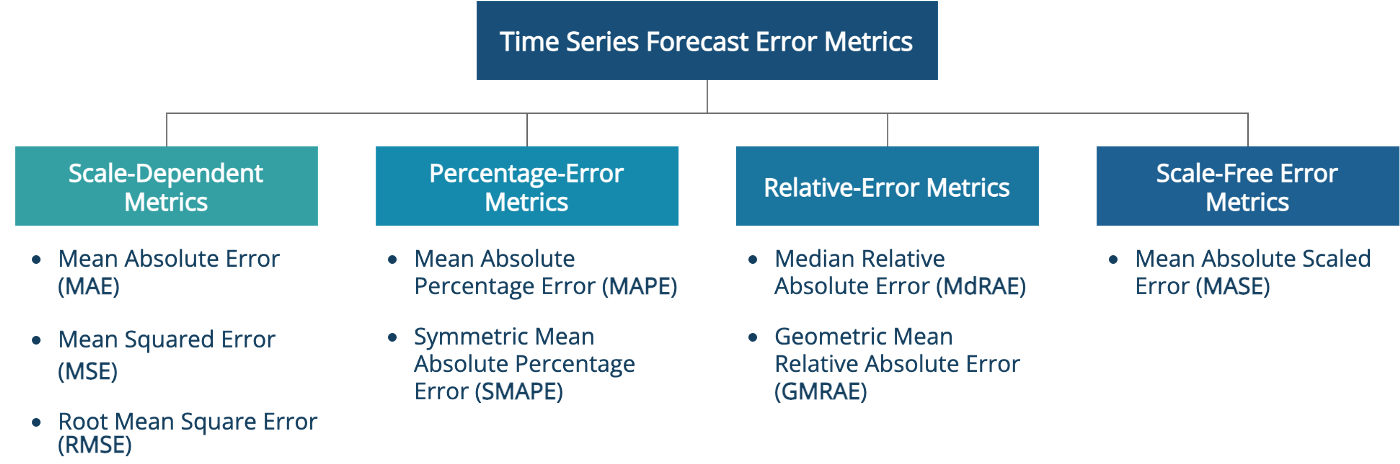

This dataset has products across various categories, thus a wide range of pricing and is sporadic in
nature; scale dependent metrics are not suitable for comparing different time series.
i.e we use percentage-error metrics or scale free error metrics;
Percentage-error metrics are scale independent and used to compare forecast performance between
different time series. However, their weak spots are zero values in a time series, Then they
become infinite or undefined which makes them not interpretable. Scale-free error metric "can be used to compare forecast methods on a single series and also to
compare forecast accuracy between series. This metric is well suited to intermittent-demand series
because it never gives infinite or undefined values except in the irrelevant case where all historical data
are equal.
Davydenko and Fildes (2013) argue that MASE introduces a bias towards overrating the performance of a
benchmark forecast as a result of arithmetic averaging and MASE is vulnerable to outliers, as a result
of dividing by small benchmark MAE values. Also due the fact that the MAE in the denominator is
using in-sample data the metric might be more tricky to explain to business users as other (more simple)
metrics.

**Evaluation metric - RMSSE**

The performance measures are first computed for each series separately by averaging their values across
the forecasting horizon and then averaged again across the series in a weighted fashion to obtain the final
scores.
The accuracy of the point forecasts will be evaluated using the Root Mean Squared Scaled Error
(RMSSE), which is a variant of the well-known Mean Absolute Scaled Error (MASE) proposed by
Hyndman and Koehler (2006). The measure is calculated for each series as follows:

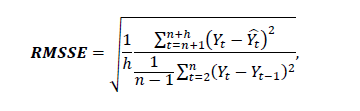

Where 𝑌𝑡 is the actual future value of the examined time series at point t, 𝑌𝑡 ̂ the generated forecast, n the
length of the training sample (number of historical observations), and h the forecasting horizon.
Note that the denominator of RMSSE is computed only for the time-periods for which the examined
product(s) are actively sold, i.e., the periods following the first non-zero demand observed for the series
under evaluation.

In [ ]:
def rmsse(data,predi):
  """returns rmsse score given the validation data and predictions"""
  cv_data=data.loc[:,'d_'+str(1914):"d_"+str(1941)]
  predi=predi.loc[:,'d_'+str(1914):'d_'+str(1941)]
  rmse=((cv_data-predi)**2).mean(axis=1)

  data=data.loc[:,'d_'+str(1):"d_"+str(1913)]
  den=[]
  for i in range(len(data)):
    row=data.loc[i].values
    row=row[np.argmax(row!=0):]
    ds=((row[1:]-row[:-1])**2).mean()
    den.append(ds)

  rmsse=((rmse/np.array(den)).map(np.sqrt)).mean()
  return rmsse

The choice of the measure is justified as follows:

• The M5 series are characterized by intermittency, involving sporadic unit sales with lots of zeros.
This means that absolute errors, which are optimized for the median, would assign lower scores
(better performance) to forecasting methods that derive forecasts close to zero. However, the
objective of M5 is to accurately forecast the average demand and for this reason, the accuracy
measure used builds on squared errors, which are optimized for the mean.

• The measure is scale independent, meaning that it can be effectively used to compare forecasts
across series with different scales.

• In contrast to other measures, it can be safely computed as it does not rely on divisions with
values that could be equal or close to zero (e.g. as done in percentage errors when 𝑌𝑡 = 0 or
relative errors when the error of the benchmark used for scaling is zero).

• The measure penalizes positive and negative forecast errors, as well as large and small forecasts,
equally, thus being symmetric.

###**Seasonal/Naive approach**

Initially , we try to forecast using basic statistical measures and useful trends observed from EDA, to evaluate these predictions we use the above designed evaluation metric(RMSSE). This would be a seasonal/naive approach towards solving the problem in hand and would act as a benchmark for better and complex models.

Few such seasonal approaches could be


1.   Weekday avg for n weeks
2.   Moving averages over n days

1.   Lag values from n days before





**Weekday avg for n weeks**

In [ ]:
b=pd.read_csv("sales_train_evaluation.csv")
nm=b.iloc[:,:6].copy()

def weekday_avg(weeks):
  '''gives rmsse score for weekday avg as predictions over weeks'''
  train_data=b.iloc[:,-(weeks*7+28):-28]
  for i in range(7):
    su=train_data.columns[i::7]
    hj=train_data[su]
    hj=hj.mean(axis=1)
    nm["avg_day_"+str(i)]=hj.round()

  for i,j in enumerate(range(1914,1942)):
    nm["d_"+str(j)]=nm["avg_day_"+str(i%7)].values

  r=rmsse(b,nm)
  print("the rmsse score for weekday avg as predictions over",weeks,"weeks is",r)

weekday_avg(4)
weekday_avg(12)
weekday_avg(52)

the rmsse score for weekday avg as predictions over 4 weeks is 0.858022961771277
the rmsse score for weekday avg as predictions over 12 weeks is 0.8223888854079816
the rmsse score for weekday avg as predictions over 52 weeks is 0.8161673757553336


Here, for each product we are taking the average sales point values over 'n' weeks for each day in the week and using it as the forecasted value for the next 28 days, week-day wise. This utilises and comprehends the trend of unique sales over each day of the week. From above results we see that we get the best rmsse value with n=52 weeks. i.e upto a limit, more data is better and weekday prediction could act as good feature for ML models.

**Moving Averages**

In [ ]:
b=pd.read_csv("sales_train_evaluation.csv")

def moving_avg(days):
  '''gives rmsse score for moving avg as predictions over recent days'''
  data=b.iloc[:,-(days+28):-28].copy()
  for j in range(1914,1942):
    data["d_"+str(j)]=data.iloc[:,-(days):].mean(axis=1).round().values

  r=rmsse(b,data)
  print("the rmsse score for moving avg as predictions over",days,"days is",r)

moving_avg(7)
moving_avg(28)
moving_avg(35)
moving_avg(42)

the rmsse score for moving avg as predictions over 7 days is 0.8269922356624088
the rmsse score for moving avg as predictions over 28 days is 0.8029993245814837
the rmsse score for moving avg as predictions over 35 days is 0.8024126299548203
the rmsse score for moving avg as predictions over 42 days is 0.802688264641945


Here, we are taking the average of the past n days and using it as the forecasted value for that day. we are getting a good rmsse value for 28,35 days after which it seems to have bottle-necked; indicating that the near past data has more value in this time-forecasting.

**Lag values**

In [ ]:
b=pd.read_csv("sales_train_evaluation.csv")

def lag_values(days):
  '''gives rmsse score for lag values as predictions on days'''
  data=b.iloc[:,-(days+28):-28].copy()
  for j in range(1914,1942):
    data["d_"+str(j)]=data.iloc[:,-(days):-(days)+1].values

  r=rmsse(b,data)
  print("the rmsse score for lag as predictions on",days,"days is",r)

lag_values(7)
lag_values(28)
lag_values(56)

the rmsse score for lag as predictions on 7 days is 0.9972420371212409
the rmsse score for lag as predictions on 28 days is 1.033331869779433
the rmsse score for lag as predictions on 56 days is 1.0505605948901002


Here , we are using the exact same sales value from n days before as the forecasted value , we are using multiples of 7 in order to account for weekday trends. This approach doesn't seem to give the best results as n increases, indicating that this is a moving time series, i.e values increase/decrease with time; values are not constant.

###**Machine Learning approach**

**Objective**: estimate, as precisely as possible, the point forecasts of the unit sales of various
products sold over a period of the next 28 days.

Typical approach towards these problems; Direct or recursive multi-step forecasting, time based splitting,
lag and rolling averages for feature engineering.

This multi-step time forecasting problem can be interpreted and solved in many ways. One such way is to convert it into a supervised data problem in order to use cutting edge Machine Learning techniques; In order to do so, we use each of the sales value that are provided for each day and product as a target value for supervised learning and other information as features that contribute to each entry. Additionally , new features can be designed and added based on the insights gained from EDA and seasonal approaches.

Since there are a huge number of induvidual products to predict and many factors that affect the price on a particular
day, which aren’t necessarily linear. Ensemble methods might work better as it uses a combination of
models that learn differently.





###**Feature Engineering**

Feature engineering includes redesigning/selecting relevant features, leveraging present data to create new variables with the goal of speeding up data transformations and increasing model performance and accuracy. The quality of data processing and feature engineering determines the performance of any particular model. These new features are designed based on domain knowledge, seen trends in such a way that it encapsulates most of the information we have.

**Redesigning exisiting features**

In the given data set; after converting it into a supervised problem, we notice that each state has its own column to represnt their SNAP sale dates. This can be converted to a single column .

Since we already have a feature "wday" to indicate the week-day number, we remove the "weekday" feature as it is redundant.

From above EDA, we see that the weekend sees a surge in sales value, this can be added as a boolean feature indicating if it is a weekend or a weekday.

In [ ]:
#Converting snap sales into a single column
l=k[(k.state_id=="TX")].copy()
l.rename(columns = {'snap_TX':'SNAP'}, inplace = True)
l=l.drop(["snap_CA","snap_WI"],axis=1)

n=k[(k.state_id=="WI")].copy()
n.rename(columns = {'snap_WI':'SNAP'}, inplace = True)
n=n.drop(["snap_CA","snap_TX"],axis=1)

k=k[(k.state_id=="CA")].copy()
k.rename(columns = {'snap_CA':'SNAP'}, inplace = True)
k=k.drop(["snap_TX","snap_WI"],axis=1)

k=pd.concat([k,l,n])
l,n=[],[]

In [ ]:
k=k.drop("weekday",axis=1)
k["is_Weekend"]=(k.wday<2).astype("bool")
k["SNAP"] = k["SNAP"].astype('bool')

**Lag and Rolling_avg features**

Seasonal approaches has showed us that lag and rolling_avg adds value as a feature. we have created lag features with a lag of 0,7,14,21,28 and 35 days. Rolling_avg features are the average of sales values per product over the past 7,14,21,28,35 and 42 days. Both types of features are created with shift of 28 days in order to accomodate the 28 days of forecasting.

In [ ]:
#shifting to account for 28 days of forecasting,
shiftt=28

#lag_features
for i in range(6):
  k["lag_"+str(shiftt+(7*i))]=k.groupby("id")["value"].shift(shiftt+(7*i)).fillna(0).astype(np.int16)

#rolling_avg over n recent days
for i in range(1,7):
  k["rolling_"+str(7*i)]=k.groupby("id")["lag_28"].transform(lambda s: s.rolling(i).mean())

downcasting(k)

**Revenue from last two years**

There is a huge amount of data , resulting in a large number of computations. Since also, we have seen that the near past data matters more when it comes to time-series, we only consider approximately the past 2 years of data. We have also observed that there are few products that have only emerged in the recent past , this favors the accurate prediction of those type of products too. There is not much change in RMSSE value due to this reduction in trainning data.

We create a feature that describes the revenue created by that particular product in a store over this recent time period.

In [ ]:
k=k[(k.day_no>=1069)]

m=k[["id","sell_price","value"]][(k.day_no<1914)].copy()
m['revenue']=(m.value*m.sell_price).values
m=m.groupby(["id"])["revenue"].sum()
m=pd.DataFrame(m)
m.reset_index(inplace=True)
k=pd.merge(k,m,on='id')

**Trends of sales on days of week and SNAP sale as a feature**

Based on the seasonal trends we have seen , we create a feature that takes the average sales values of that particular day of the week over the whole time-period. This has been done induvidually for SNAP and Non-SNAP days in order to create more distinction and add value in regard to SNAP sale dates.

In [ ]:
m=k[(k.day_no<1914)][["id","wday","state_id","SNAP","value"]].copy()
m.rename(columns = {'value':'trend_value'}, inplace = True)
m=m.groupby(["id","wday","SNAP","state_id"])["trend_value"].mean()
m=pd.DataFrame(m)
m.reset_index(inplace=True)
k=pd.merge(k,m,on=["id","wday","SNAP","state_id"])
downcasting(k)

**Label encoding**

Finally , after creating all the relevant features and modifying the existing ones, there is a need to integer encode them in such a way that the model understands; this can be done by categorically/ordinal encoding or label encoding. This is necessary in order for the model to make sense of the categories we have. Since python by default uses object type , we first convert the categorical features into category type before encoding.

This encoding is then saved to a dictionary in order for future encoding of real-time test data.

Now this labelled data can be stored and used for modelling.

In [ ]:
cat_cols = ['id','item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'date', 'wday', 'month',
            'year', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'SNAP']
for col in cat_cols:
    k[col] = k[col].astype('category')

def label_encoding(df,cols):
    for col in cols:
        lenc = LabelEncoder()
        df[col] = lenc.fit_transform(df[col].astype(str)).astype(np.int16)
    return df
k = label_encoding(k,cat_cols)
downcasting(k)

In [ ]:
#Pickling data
filename = 'final_labelled'
outfile = open(filename,'wb')
pickle.dump(k,outfile)
outfile.close()

### **Modelling**

After Feature engineering, we divide the whole data into Train, validation and test datasets for modelling. Although we have converted this into a supervised problem, it is still a time series one and is evaluated based on the predictions we make on the final 28 days of data (validation) and the next 28 days of forecasting (evaluation). Thus, we split it in the way mentioned.

Initially we'll try using basic ML models like linear regression, followed by more complex ensemble models like Random Forest and Gradient boosting. After this we try to incoporate a custom model based on the information and the best model we already have, aiming to produce better predictions and a lower RMSSE score.

In [ ]:
#retreiving data from pickle file
infile = open('final_labelled','rb')
k = pickle.load(infile)
infile.close()

**Train, Validation and Test split**

In [ ]:
X_tr = k[(k.day_no<=1913)].drop(['value'],axis=1).copy()
y_tr = k[(k.day_no<=1913)]['value'].copy()

X_val = k[(k.day_no>=1914) & (k.day_no<=1941)].drop(['value'],axis=1).copy()
y_val = k[(k.day_no>=1914) & (k.day_no<=1941)]['value'].copy()

X_te = k[(k.day_no>=1942)].drop(['value'],axis=1).copy()

We are considering the last 2 years of data, the final 28 days (1914-1941) of data is used for validation , the data before that is training and the days used for test forcasting are (1942-1969).

We use the training data to train the models and the RMSSE score of validation data predictions to tune the model hyperparameters. After getting the best model , we use it to get predictions for the test dataset and then combine the validation and evaluation predictions in a format that is prescribed for the final WRMSSE score and submission on Kaggle.

**Submission format conversion**

In [ ]:
#submission_conversion
def subb(modell,b):
  """converts predictions to the required submission format"""
    m=pd.DataFrame()
    n=pd.DataFrame()
    n["id"]=b["id"].copy()
    m["id"]=b["id"].apply(lambda x: x.replace('evaluation','validation')).copy()
    for a,l in enumerate(range(1914,1942)):
            m['F'+str(a+1)] = modell.predict(X_val[X_val['day_no']==l])
    for v,s in enumerate(range(1942,1970)):
            n['F'+str(v+1)] = modell.predict(X_te[X_te['day_no']==s])
    return m,n

####**linear regression**

In [ ]:
scalar = StandardScaler()
X_tr_sc = scalar.fit_transform(X_tr)
X_val_sc = scalar.fit_transform(X_val)

alpha_lst = [0.0001,0.001,0.01,0.1,0.5,0.7,1]
resultss1={}
b=pd.read_csv("sales_train_evaluation.csv")

for i in tqdm(alpha_lst):
    lr_reg_best = SGDRegressor(alpha=i,loss='squared_error',early_stopping=True)
    lr_reg_best.fit(X_tr_sc,y_tr.values)
    sgd_predictions = lr_reg_best.predict(X_val_sc)
    
    start = 0
    t = int(X_val.iloc[0]['day_no'])
    sgd_pred_df = pd.DataFrame()
    while start < len(sgd_predictions):
        end = start + 30490
        sgd_pred_df['d_'+str(t)] = sgd_predictions[start:end]
        start = end
        t = t+1

    rmse=rmsse(b,sgd_pred_df)
    resultss1[i]=rmse

resultss1

100%|████████████████████████████████████████████████████████████████████████████| 7/7 [09:56<00:00, 85.25s/it]


{0.0001: 2.1216929763822354,
 0.001: 1.9510531930381132,
 0.01: 1.9704165465745402,
 0.1: 1.9545766526832131,
 0.5: 1.5861074183303259,
 0.7: 2.014051496299816,
 1: 1.9659883632057085}

We first model with a basic SGDRegressor from scikitlearn, since it is linear regression there is a need for standardisation. Linear regression is a basic ML technique which tries to plot all the data points to a multi-dimensional line which fits the data with minimal loss, the loss function we are using here is squared-loss. Here we are using L2 regularization and the hyperparameter is the regularization constant alpha; we try with 7 different values/ranges of alpha. The best RMSSE score we get is with alpha=0.5 (1.5861) which is still lower than the benchmark we set from the seasonal approaches i.e we forgo this model.

####**Random Forest Regressor**

In [ ]:
#RF
best_alpha = [50,75,100]
best_d = 12
results_rf={}
b=pd.read_csv("sales_train_evaluation.csv")

for i in tqdm(best_alpha):
    final_predictions_rf = pd.DataFrame()
    rf_reg_best = RandomForestRegressor(n_estimators=i, max_depth=best_d,n_jobs=-1)
    rf_reg_best.fit(X_tr,y_tr)
    for l in range(1914,1942):
        final_predictions_rf['d_'+str(l)] = rf_reg_best.predict(X_val[X_val['day_no']==l])
    rmse=rmsse(b,final_predictions_rf)
    results_rf[i]=rmse

results_rf

100%|████████████████████████████████████████████████████████████████████████| 3/3 [3:35:51<00:00, 4317.26s/it]


{50: 0.7711612262576466, 75: 0.7709930840617585, 100: 0.7709814789475057}

In [ ]:
m,n=subb(rf_reg_best,b)
sub=pd.concat([m,n])
sub.to_csv(str(rf_reg_best)+"submission.csv",index=False)

Next, we model using an ensemble technique called Random Forest , it is a decission tree based model that accomodates non-linear relationships. It uses impactful strategies like bagging (bootstrap aggregation) to create randomness and gini impurity to select the most meaningful features. The hyperparameter we are tuning here is the number of estimator(decission trees). 100 trees gives us the best RMSSE score of 0.7709, which is considerably better than our benchmark models. Thus , we save the best model and use its predictions to get the final WRMSSE on kaggle. This method as observed, is computationally expensive for the size of data we seem to have.

####**LGBM Regressor**

In [ ]:
#lgbm
alpha_lst = [50,75,100,125] 
lr_lst = [0.025,0.05,0.075]
resultss={}
b=pd.read_csv("sales_train_evaluation.csv")

for i in tqdm(alpha_lst):
    for j in lr_lst:
        final_predictions_lgb = pd.DataFrame()
        lgb_reg_best = lgb.LGBMRegressor(num_leaves=i,n_estimators=100,learning_rate=j,n_jobs=-1)
        lgb_reg_best.fit(X_tr,y_tr)
        for l in range(1914,1942):
            final_predictions_lgb['d_'+str(l)] = lgb_reg_best.predict(X_val[X_val['day_no']==l])
        rmse=rmsse(b,final_predictions_lgb)
        resultss[(i,j)]=rmse

resultss

100%|███████████████████████████████████████████████████████████████████████████| 4/4 [24:46<00:00, 371.69s/it]


{(50, 0.025): 0.7807935347164088,
 (50, 0.05): 0.7716852724059484,
 (50, 0.075): 0.7704156472737326,
 (75, 0.025): 0.7798334385741752,
 (75, 0.05): 0.7712594142099646,
 (75, 0.075): 0.7699290143104348,
 (100, 0.025): 0.7789410021102628,
 (100, 0.05): 0.7706990772168363,
 (100, 0.075): 0.7695644874928829,
 (125, 0.025): 0.778468624255944,
 (125, 0.05): 0.7708180858588616,
 (125, 0.075): 0.7697712286186449}

In [ ]:
#best_model
alpha_lst = [100] 
lr_lst = [0.075]
resultss={}
b=pd.read_csv("sales_train_evaluation.csv")

for i in tqdm(alpha_lst):
    for j in lr_lst:
        final_predictions_lgb = pd.DataFrame()
        lgb_reg_best = lgb.LGBMRegressor(num_leaves=i,n_estimators=100,learning_rate=j,n_jobs=-1)
        lgb_reg_best.fit(X_tr,y_tr)
        for l in range(1914,1942):
            final_predictions_lgb['d_'+str(l)] = lgb_reg_best.predict(X_val[X_val['day_no']==l])
        rmse=rmsse(b,final_predictions_lgb)
        resultss[(i,j)]=rmse

resultss

100%|███████████████████████████████████████████████████████████████████████████| 1/1 [02:03<00:00, 123.67s/it]


{(100, 0.075): 0.7695644874928829}

In [ ]:
m,n=subb(lgb_reg_best)
sub=pd.concat([m,n])
sub.to_csv(str(modell)+"submission.csv",index=False)

Now , we try another powerful ensemble technique called Gradient Boosting, as the name suggests it a technique that implements boosting. Here, we are using LGBMRegressor as it is much faster and gives us better results than other boosting techniques owing to its limited leaf based approach. The hyperparameters we are tuning here are the number of leaves and the learning rate, we are keeping the number of trees/estimators as a constant 100.

The combination of n_leaves=100 and Learning rate of 0.075 seems to give the best results, we use this as our best model and get our predictions to get our final WRMSSE score. it performs way faster than Random forest and gives somewhat considerably better results.

####**Custom Model**

In [ ]:
#custom models

alpha_lst = [50,75,100,125] 
lr_lst = [0.025,0.05,0.075]
resultss={}
b=pd.read_csv("sales_train_evaluation.csv")
b['state_id'] = LabelEncoder().fit_transform(b['state_id'].astype(str)).astype(np.int8)

for state in tqdm(range(3)):
  bs = b[(b.state_id==state)].reset_index(drop=True)
  ks = k[(k.state_id==state)]
  X_tr = ks[(ks.day_no<=1913)].drop(['value'],axis=1).copy()
  y_tr = ks[(ks.day_no<=1913)]['value'].copy()

  X_val = ks[(ks.day_no>=1914) & (ks.day_no<=1941)].drop(['value'],axis=1).copy()
  y_val = ks[(k.day_no>=1914) & (ks.day_no<=1941)]['value'].copy()

  for i in alpha_lst:
    for j in lr_lst:
      final_predictions_lgb = pd.DataFrame()
    
      lgb_reg_best = lgb.LGBMRegressor(num_leaves=i,n_estimators=100,learning_rate=j,n_jobs=-1)
      lgb_reg_best.fit(X_tr,y_tr)
      for l in range(1914,1942):
          final_predictions_lgb['d_'+str(l)] = lgb_reg_best.predict(X_val[X_val['day_no']==l])
      rmse=rmsse(bs,final_predictions_lgb)
      resultss[(state,i,j)]=rmse

resultss

  0%|                                                                                    | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
100%|███████████████████████████████████████████████████████████████████████████| 3/3 [25:17<00:00, 505.74s/it]


{(0, 50, 0.025): 0.7917314232397429,
 (0, 50, 0.05): 0.7829049498688934,
 (0, 50, 0.075): 0.7809801154602862,
 (0, 75, 0.025): 0.7907939971130769,
 (0, 75, 0.05): 0.7821885691375107,
 (0, 75, 0.075): 0.7807149654713622,
 (0, 100, 0.025): 0.7900846848876103,
 (0, 100, 0.05): 0.7817700774303498,
 (0, 100, 0.075): 0.7802274883672938,
 (0, 125, 0.025): 0.7895322865404475,
 (0, 125, 0.05): 0.7815145301728341,
 (0, 125, 0.075): 0.7800265458182518,
 (1, 50, 0.025): 0.7505457880004606,
 (1, 50, 0.05): 0.7398118684700976,
 (1, 50, 0.075): 0.7392635663443831,
 (1, 75, 0.025): 0.7491199023725966,
 (1, 75, 0.05): 0.7395496638506118,
 (1, 75, 0.075): 0.7390184522940196,
 (1, 100, 0.025): 0.748301820401663,
 (1, 100, 0.05): 0.739446618581663,
 (1, 100, 0.075): 0.7388617311026462,
 (1, 125, 0.025): 0.7479555865470476,
 (1, 125, 0.05): 0.7393179037837252,
 (1, 125, 0.075): 0.7386810491072064,
 (2, 50, 0.025): 0.7950931663657193,
 (2, 50, 0.05): 0.7852657436924094,
 (2, 50, 0.075): 0.783888269565264,
 

In [ ]:
#custom models_best

alpha_lst =125
lr_lst = 0.075
resultss={}

b=pd.read_csv("sales_train_evaluation.csv")
b['state_id'] = LabelEncoder().fit_transform(b['state_id'].astype(str)).astype(np.int8)
custom_predictions_val=pd.DataFrame()
custom_predictions_eval=pd.DataFrame()

for state in tqdm(range(3)):
  bs = b[(b.state_id==state)].reset_index(drop=True)
  ks = k[(k.state_id==state)]
  X_tr = ks[(ks.day_no<=1913)].drop(['value'],axis=1).copy()
  y_tr = ks[(ks.day_no<=1913)]['value'].copy()

  X_val = ks[(ks.day_no>=1914) & (ks.day_no<=1941)].drop(['value'],axis=1).copy()
  y_val = ks[(k.day_no>=1914) & (ks.day_no<=1941)]['value'].copy()

  X_te = ks[(ks.day_no>=1942)].drop(['value'],axis=1).copy()  

  final_predictions_lgb = pd.DataFrame()
  lgb_reg_best = lgb.LGBMRegressor(num_leaves=alpha_lst,n_estimators=100,learning_rate=lr_lst,n_jobs=-1)
  lgb_reg_best.fit(X_tr,y_tr)
  for l in range(1914,1942):
        final_predictions_lgb['d_'+str(l)] = lgb_reg_best.predict(X_val[X_val['day_no']==l])
  rmse = rmsse(bs,final_predictions_lgb)
  resultss[str(state)]=rmse
    
  m,n = subb(lgb_reg_best,bs)
  if custom_predictions_val.empty:
        custom_predictions_val=m
        custom_predictions_eval=n
  else:
    custom_predictions_val=pd.concat([custom_predictions_val,m])
    custom_predictions_eval=pd.concat([custom_predictions_eval,n])
    
custom_predictions = pd.concat([custom_predictions_val,custom_predictions_eval])
custom_predictions.to_csv("custom_predictions.csv",index=False)
custom_predictions_val.columns=["id"]+["d_"+str(i) for i in range(1914,1942)]
#custom_predictions_val=custom_predictions_val.reset_index(drop=True)
rmse = rmsse(b,custom_predictions_val.reset_index(drop=True))
resultss['final']=rmse
resultss

100%|████████████████████████████████████████████████████████████████████████████| 3/3 [02:50<00:00, 56.76s/it]


{'0': 0.7800265458182518,
 '1': 0.7386810491072064,
 '2': 0.7830633226608037,
 'final': 0.768533929857704}

From all the modelling techniques we have implemented above , we have seen that LGBMRegressor gives the best and faster results. Also, that every state/ store has unique variations in sales values; we can combine this information to create a custom model(s). To ease the load on the model and to increase forecasting accuracy, we can have a seperate model for each state or rather each store. In the above implementation , we have trained three seperate models for three induvidual states, with its respective data accordingly and then combined the predictions in a format to get the final WRMSSE score. LGBMRegressor has been used, the best hyperparameters for all the three implementations are the same i.e num_leaves=125 and a learning rate of 0.075. This custom model seems to have better performance than the techniques implemented before.

####**Feature importance**

After getting the best model, we check the feature importance to know how much a particular feature has contributed towards the decession making of that model. feature importance allows us to analyze and design better features going ahead.

analyzing the feature importance of our custom model, gives us three sets of slightly varying feature importances; state wise.
Here, we can see how good and efficient feature engineering bears fruit. The features we designed like trend_value , revenue , lag_features, rolling_avg features seem to have high importance across all state_models i.e adding value.

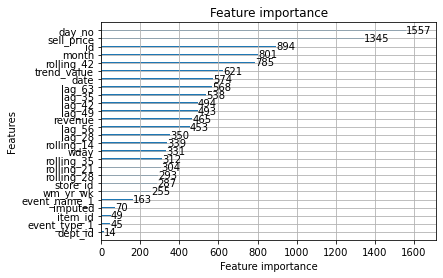

In [ ]:
#CA_model
a=best_models[0]
lgb.plot_importance(a)
plt.show()

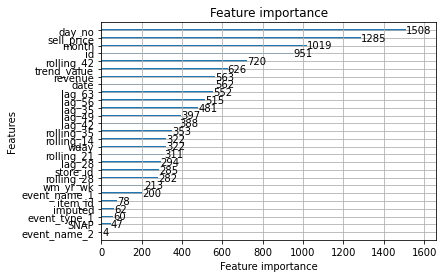

In [ ]:
#TX_model
a=best_models[1]
lgb.plot_importance(a)
plt.show()

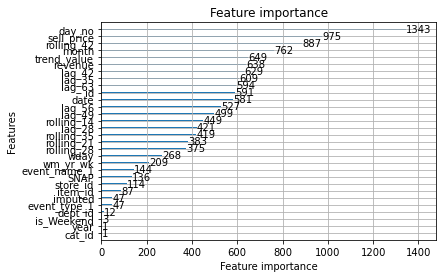

In [ ]:
#WI_model
a=best_models[2]
lgb.plot_importance(a)
plt.show()

####**Results**

In [ ]:
myTable = PrettyTable(["Method/Model", "Best Parameter"," Best RMSSE Score"])

myTable.add_row(["Weekday average for 'n' weeks", "52 weeks", "0.8161"])
myTable.add_row(["Moving average of 'n' days", "35 days", "0.8024"])
myTable.add_row(["Lag value of 'n' days before", "7 days", "0.9972"])
myTable.add_row(["SGDRegressor with L2 reg.", "alpha=0.5", "1.5861"])
myTable.add_row(["Random Forest Regressor", "n_estimators=100", "0.7709"])
myTable.add_row(["LGBM Regressor", "n_leaves=100, L.R=0.075", "0.7695"])
myTable.add_row(["Custom model with LGBM", "n_leaves=125, L.R=0.075", "0.7685"])
  
print(myTable)

+-------------------------------+-------------------------+-------------------+
|          Method/Model         |      Best Parameter     |  Best RMSSE Score |
+-------------------------------+-------------------------+-------------------+
| Weekday average for 'n' weeks |         52 weeks        |       0.8161      |
|   Moving average of 'n' days  |         35 days         |       0.8024      |
|  Lag value of 'n' days before |          7 days         |       0.9972      |
|   SGDRegressor with L2 reg.   |        alpha=0.5        |       1.5861      |
|    Random Forest Regressor    |     n_estimators=100    |       0.7709      |
|         LGBM Regressor        | n_leaves=100, L.R=0.075 |       0.7695      |
|     Custom model with LGBM    | n_leaves=125, L.R=0.075 |       0.7685      |
+-------------------------------+-------------------------+-------------------+


**Kaggle submissions and scores**

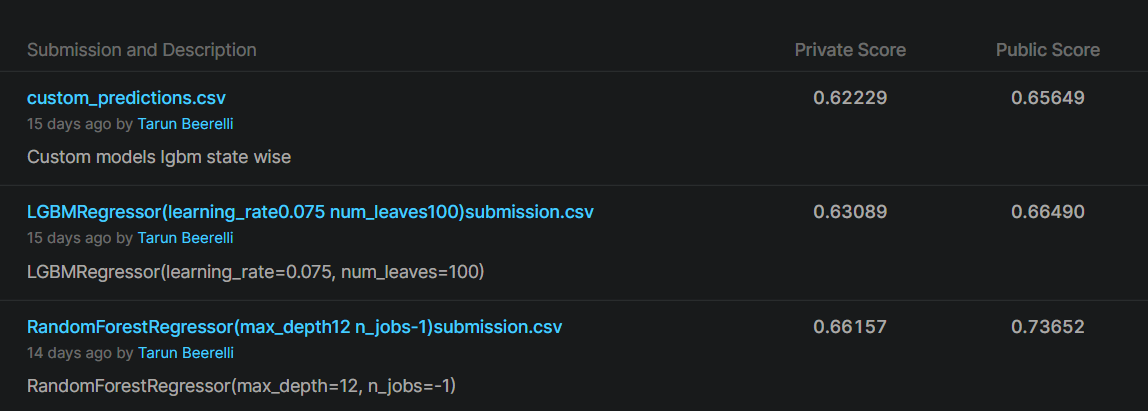

Using the initial three approaches as a benchmark , we have tried a few ML techniques; out of which linear regression doesn't meet the required standards, Random forest Regressor and LGBRegressor seem to perform good but the custom model with LGBMR tops the charts with the best RMSSE and WRMSSE score.

The predictions from this custom model , when verified on Kaggle; gave a private score of 0.6229 which as of now would be ranked 186 on the leaderboard with a total of 5533 participants/teams, accounting to be in the **Top 4%**.

##**Deployment**

The final step, is to make available the results and for anyone/staff to access and predict/forecast the demand of a particular product in a particular store for the next 28 days in order to take necessary descissions.

This can be done by deploying the model, to predict in real-time. Depending on the scale of outreach; the technology required varies. Here i have used a simple Flask app to deploy this model in order to give real time predictions when demanded. It takes the product and store ID as input , pulls out data from the repository and uses the custom/best model to give the predictions.

It gives an error message if the product id entered isn't valid/ not in the database, store id can be chosen from the dropdown.

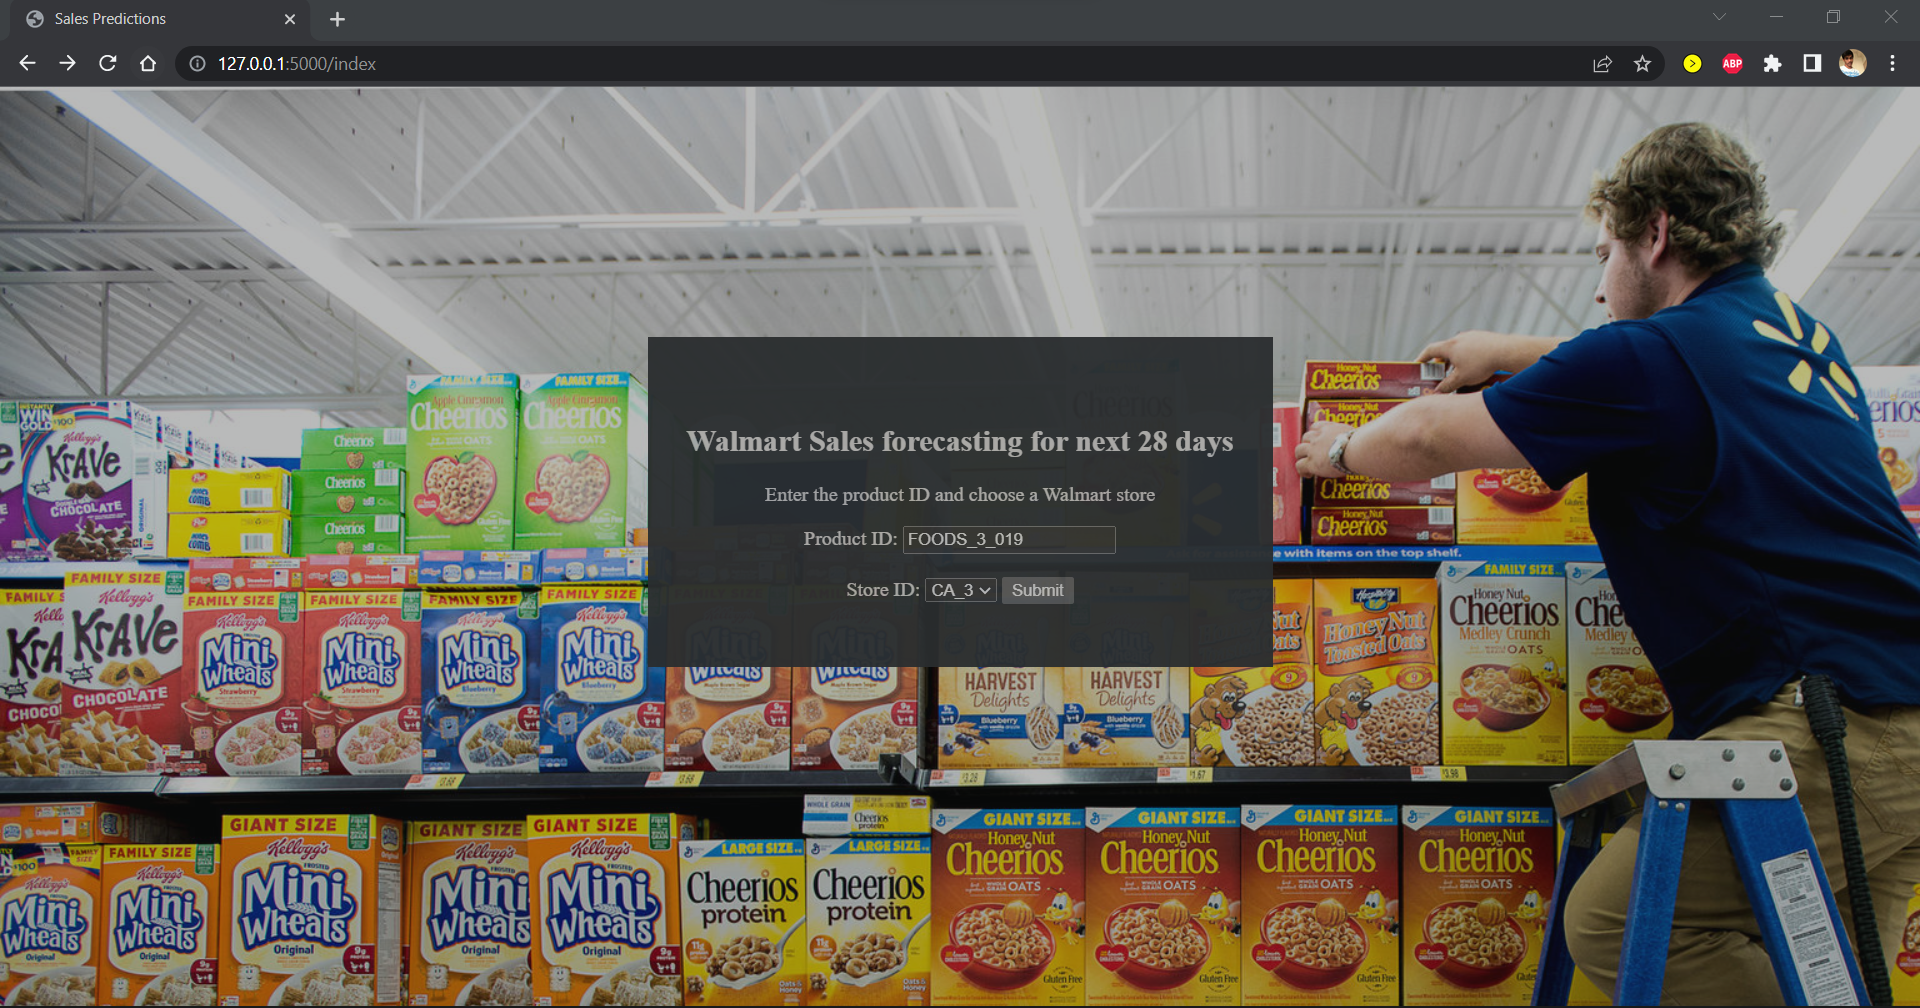

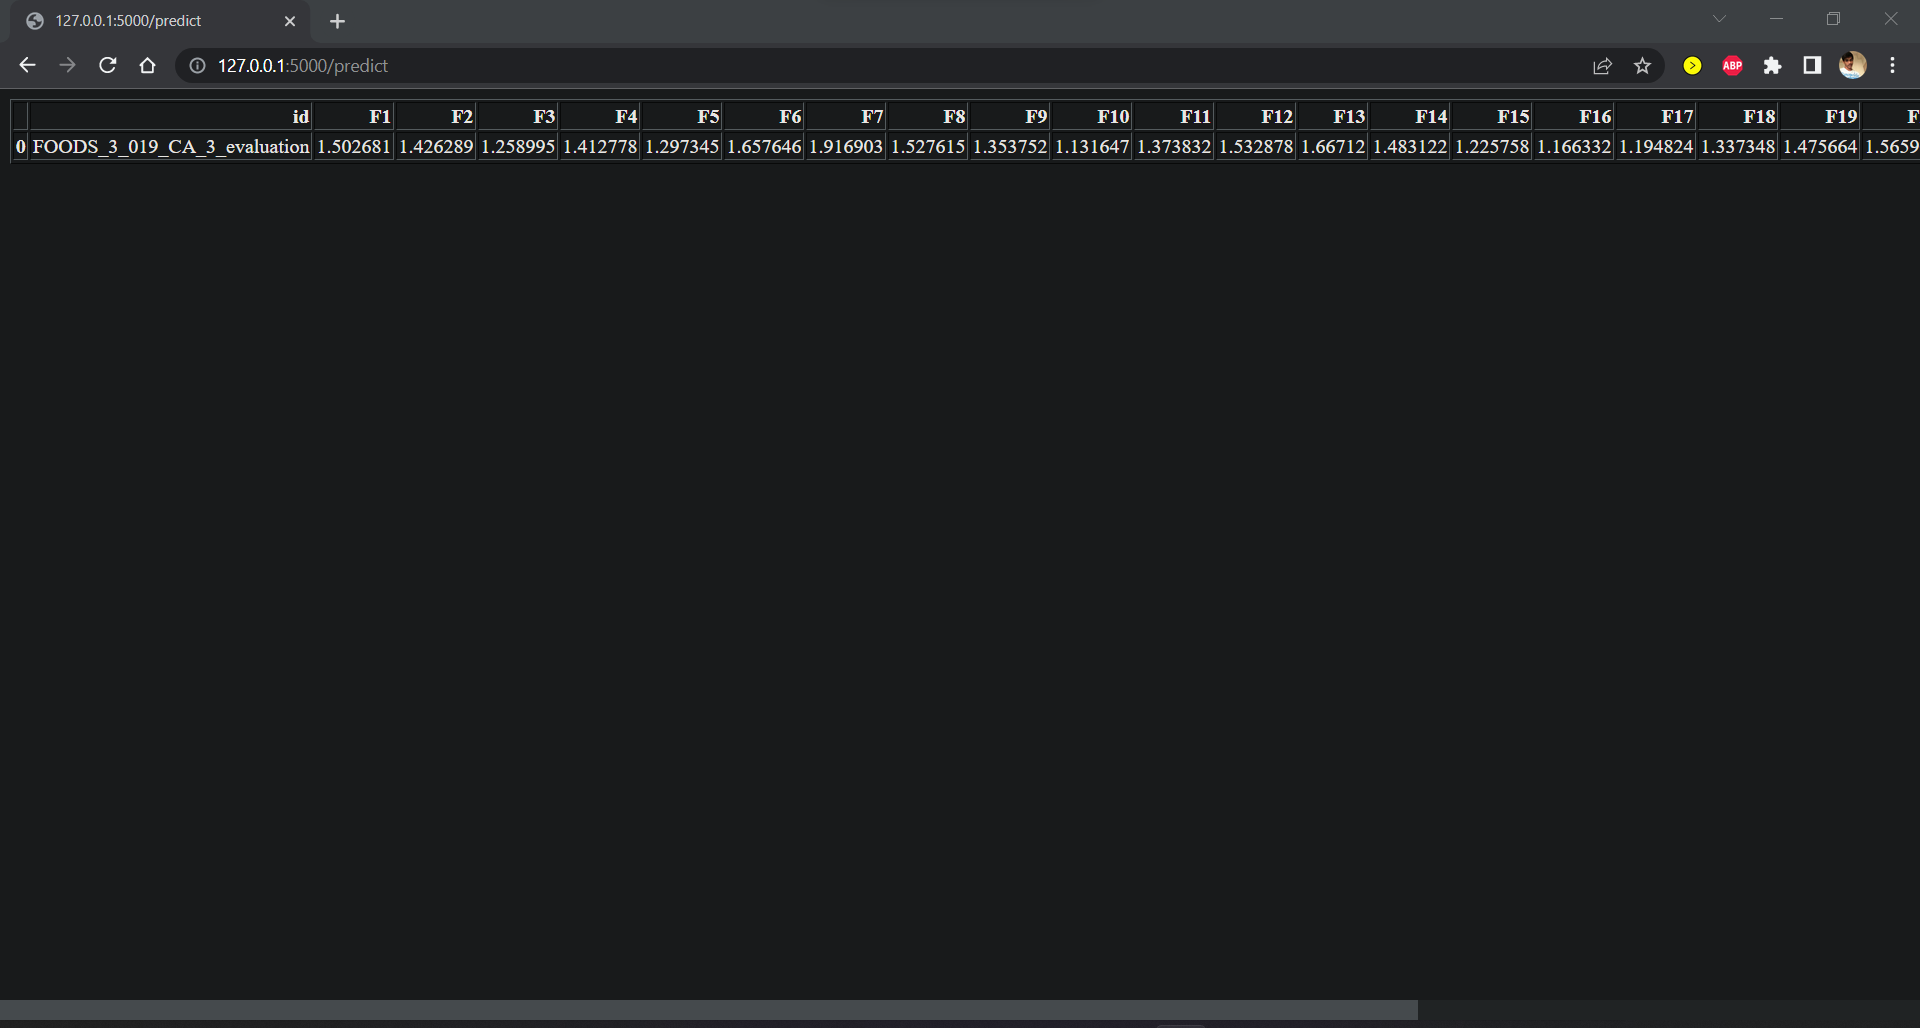

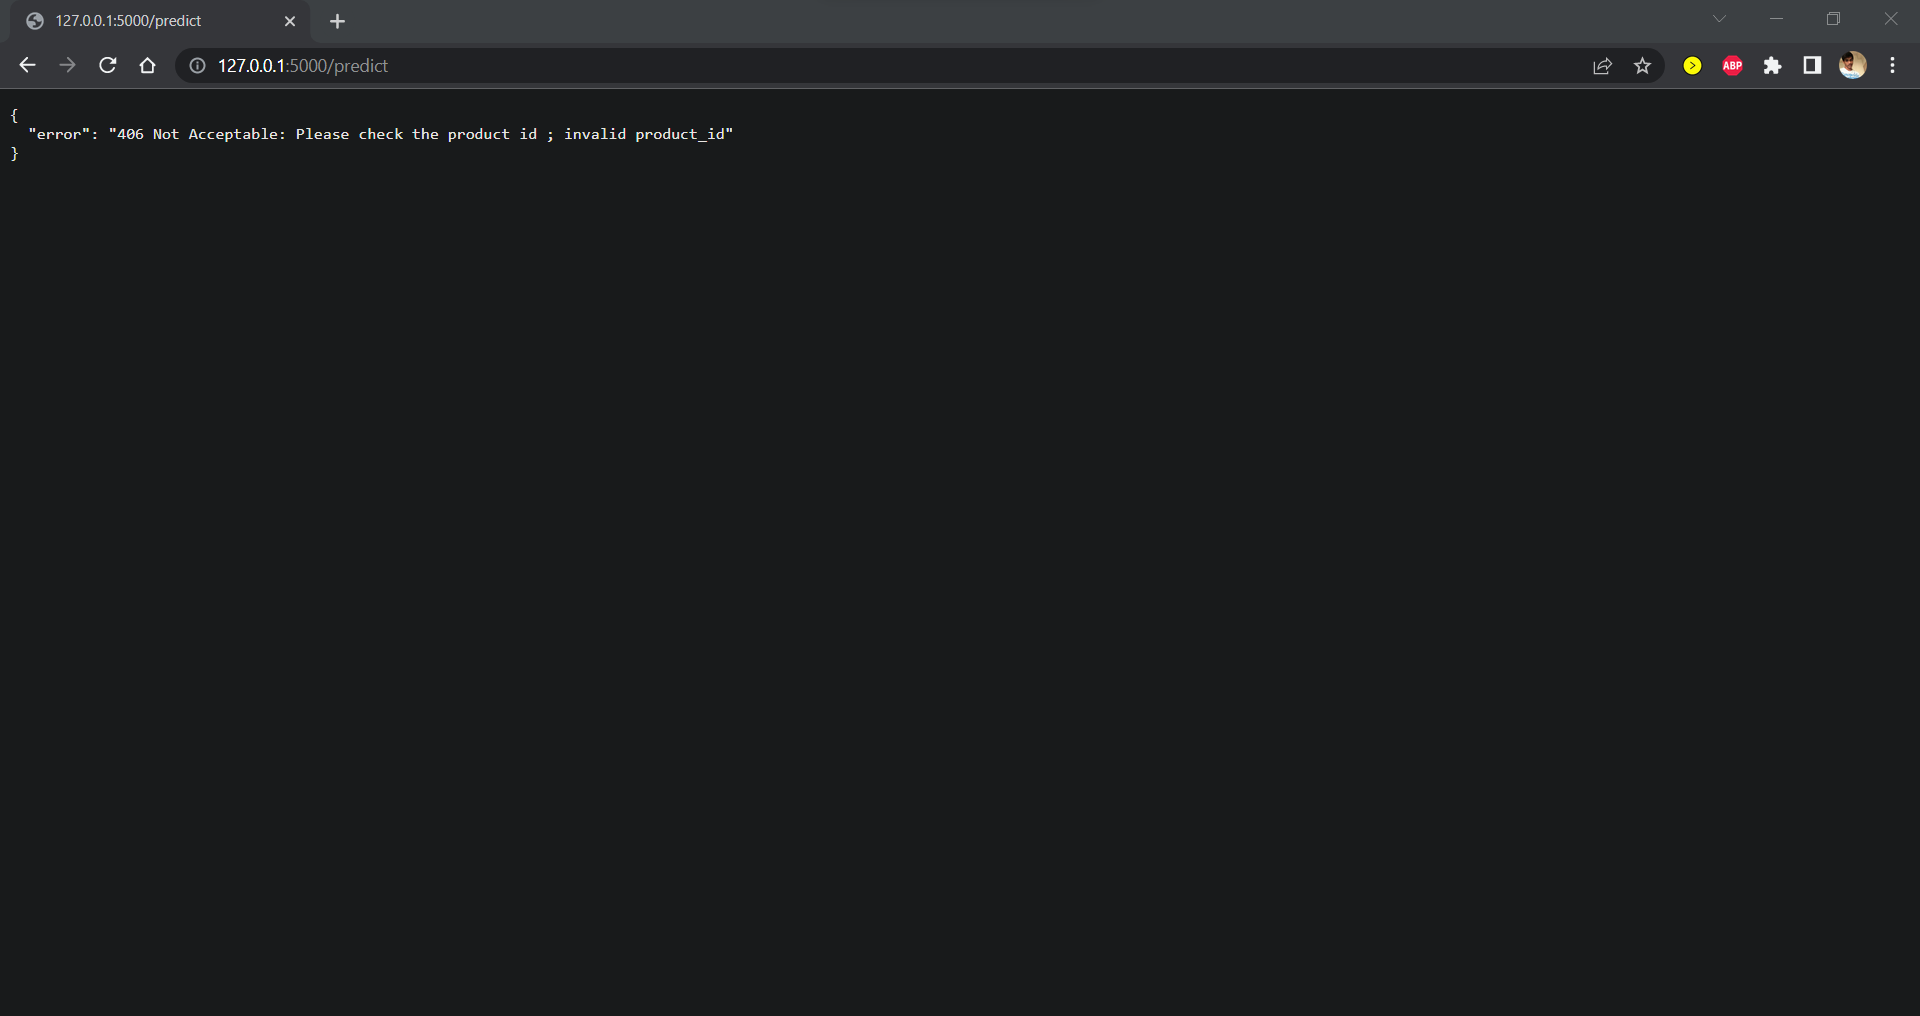